<a href="https://colab.research.google.com/github/leejunho12316/P-Project-Machine-Learning/blob/main/P_project_reliability_model_ver2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install -U "tensorflow-text==2.13.*"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 36.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 479.7/479.7 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 65.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 67.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 43.0 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.14.0
    Uninstalling tensorflow-estimator-2.14.0:
      Successfully uninstalled tensorflow-estimator-2.14.0
  Attempting uninstall: keras
    Found existing installation: keras 2.14.0
    Uninstalling keras-2.14.0:
      Successfully uninstalled keras-2.14.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.4
    Uninstalling gast-0.5.4:
      Successfully uninstalled gast-0.5.4
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.14.1
    

In [2]:
pip install "tf-models-official==2.13.*"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 35.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.3/106.3 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 52.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 27.4 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=7ca920ecadf8eecaed3d66da60ecdcff9ac59ed6a1edde6e703f72e6a262ccb0
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [3]:
from google.colab import drive
import shutil
import os
import zipfile

import json

아이디어
1. NonClickBait, ClickBait 이진분류
본문의 제목, 본문만 학습해 이진분류를 진행한

2. 주제 자동감지 다중분류
Topic을 참고해 클래스를 나누어 제목과 본문을 학습시키고 기사 입력시 주제 자동감지

### **1. 데이터 준비**

내 Google Drive에서 데이터 다운로드

In [9]:
drive.mount('/content/drive')

source_path = '/content/drive/MyDrive/ML_Data/146.낚시성 기사 탐지 데이터.zip'
destination_path = '/content/146.낚시성 기사 탐지 데이터.zip'
shutil.copyfile(source_path,destination_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/content/146.낚시성 기사 탐지 데이터.zip'

 zip 압축 풀기

In [10]:
#한글파일 unzip시 깨짐 encoding decoding으로 방지하는 함수
def unzip(source_path, dest_path):
  with zipfile.ZipFile(source_path, 'r') as zf:
    zipInfo = zf.infolist()
    for member in zipInfo:
      try:
        #print(member.filename.encode('cp437').decode('euc-kr','ignore'))
        member.filename = member.filename.encode('cp437').decode('euc-kr','ignore')
        zf.extract(member,dest_path)
      except:
        print(source_path)
        raise Exception('??')

zip_file_path = '/content/146.낚시성 기사 탐지 데이터.zip'
unzip(zip_file_path,'/content')

**[경로]** 내부의 모든 zip file 해당 위치에 압축 해제

In [11]:
raw_data_path1 = '/content/146.낚시성 기사 탐지 데이터/01.데이터/Training/02.라벨링데이터'
raw_data_path2 = '/content/146.낚시성 기사 탐지 데이터/01.데이터/Validation/02.라벨링데이터'
for p in [raw_data_path1,raw_data_path2]:
  for root, dirs, files in os.walk(p):
    for file_name in files:
      if file_name.endswith('.zip'):
        start_path = os.path.join(root,file_name)
        dest_path = os.path.join(root,file_name[:-4])
        if os.path.exists(dest_path):
          pass
        else:
          os.mkdir(dest_path)
        unzip(start_path,dest_path)

### **2. 데이터 탐색**

**기본 데이터 특징**


*   원천데이터에는 Part1 Clickbait의 Direct와 Auto가 누락되어있음
*   항목 추가



**partNum**P1, P2 그냥 파트 정보
**useType** 0낚시성 1비낚시성
**processType** A자동생성 D직접생성

**processPattern (json-sourceDataInfo - processPattern)**
*   Part1은 11부터16까지, Part2는 21부터24까지.
*   Part1이든 Part2이든 Clickbait_Direct 에만 processPattern이 유의미한 값을 가짐. Direct(직접생성)이 아닌 Auto(자동생성)이면 NonClickbait은 00 Clickbait은 99값을 가짐

11. 의문 유발형(부호)
12. 의문 유발형(은닉)
13. 선정표현 사용형
14. 속어
15. 사실과대표현
16. 의도적 주어 왜곡
21. 상품 판매정보
22. 부동산 판매정보
23. 서비스 판매정보
24. 의도적 상황 왜곡/전환



In [ ]:
#folder_path의 json파일 다 읽어서 param 개수 저장
folder_path = '/content/146.낚시성 기사 탐지 데이터/01.데이터/Training/01.원천데이터/TS_Part2_Clickbait_Auto_EC'
param = 'processType'
all_param = {}

for root, dirs, files in os.walk(folder_path):
  for file_name in files:
    if file_name.endswith('.json'):
      with open(root+'/'+file_name,'r') as f:
        data=json.load(f)
        #json 데이터 key값으로 찾는 방법
        res = data.get('sourceDataInfo').get(param)

        all_param[res] = all_param.get(res,0) + 1

all_param

{}

**원천 데이터와 라벨링 데이터 차이**

*   라벨링 데이터에 **labeledDataInfo**가 추가되어있다는 것만 다르다
*   빌어먹을 Part1의 Clickbait 데이터가 원천데이터에는 없고 라벨링데이터에만 있다



In [ ]:
#원천데이터와 라벨링데이터의 같은 이름의 데이터가 어떻게 다른지 탐색
raw_path1 = '/content/146.낚시성 기사 탐지 데이터/01.데이터/Training/01.원천데이터/TS_Part2_Clickbait_Direct_EC/EC_M02_617507.json'
labeled_path1 = '/content/146.낚시성 기사 탐지 데이터/01.데이터/Training/02.라벨링데이터/TL_Part2_Clickbait_Direct_EC/EC_M02_617507_L.json'

#json파일 여는 방법
with open(raw_path1,'r') as rf:
  raw_data = json.load(rf)
with open(labeled_path1,'r') as lf:
  labeled_data = json.load(lf)

print(raw_data)
print()
print(labeled_data)

FileNotFoundError: ignored

원천데이터의 newsTitle 과 라벨링데이터의 newTitle

In [ ]:
from IPython.display import clear_output
import time

labeled_path2 = '/content/146.낚시성 기사 탐지 데이터/01.데이터/Training/02.라벨링데이터/TL_Part2_Clickbait_Direct_PO'
file_list = []
for root, dirs, files in os.walk(labeled_path2):
  for file_name in files:
    if file_name.endswith('.json'):
      file_list.append(root+'/'+file_name)

for i in range(60,4000):
  #i = int(input("숫자 :"))

  with open(file_list[i],'r') as f:
    data = json.load(f)

  clear_output(wait=False)
  print(f"{'Part1 - ' if 'Part1' in file_list[i] else 'Part2 - '}", end='')
  print(f"{'NC - ' if 'NonClickbait' in file_list[i] else 'C - '}", end='')
  print(f"{'Auto' if 'Auto' in file_list[i] else 'Direct'}")

  print(f"입력 : {i}")
  print(f"원문 제목:  {data.get('sourceDataInfo').get('newsTitle')}")
  print(f"새로운 제목:  {data.get('labeledDataInfo').get('newTitle')}")
  print()

  time.sleep(3.3)

Training, Validation 폴더의 데이터는 다름,
1:1로 나누어져있음

In [ ]:
a = '/content/146.낚시성 기사 탐지 데이터/01.데이터/Training/02.라벨링데이터'
b = '/content/146.낚시성 기사 탐지 데이터/01.데이터/Validation/02.라벨링데이터'
sum=0
for root, dirs, files in os.walk(a):
  sum += len(files)

print("a: ", sum)
print()

for root, dirs, files in os.walk(b):
  sum+=len(files)
print("b: ",sum)

print()

### **3. 데이터 준비**
**낚시성 기사 분류 모델** 학습에 쓰일 데이터 준비 - Clickbait Nonclickbait 분류

정제데이터를 저장할 폴더 다 만들기

In [12]:
#root - training&test - nc&c 폴더 다 만들기
root_path = '/content/root'
training_path = os.path.join(root_path,'training')
test_path = os.path.join(root_path,'test')

training_nc_path = os.path.join(training_path,'nc')
training_c_path = os.path.join(training_path,'c')
test_nc_path = os.path.join(test_path,'nc')
test_c_path = os.path.join(test_path,'c')

all_paths = [root_path, training_path, test_path, training_nc_path, training_c_path, test_nc_path, test_c_path]
for path in all_paths:
  if not os.path.exists(path):
    os.makedirs(path)
    print(f"{path} 폴더를 만들었습니다.")
  else:
    print(f"{path} 폴더는 이미 존재합니다.")

/content/root 폴더를 만들었습니다.
/content/root/training 폴더를 만들었습니다.
/content/root/test 폴더를 만들었습니다.
/content/root/training/nc 폴더를 만들었습니다.
/content/root/training/c 폴더를 만들었습니다.
/content/root/test/nc 폴더를 만들었습니다.
/content/root/test/c 폴더를 만들었습니다.


txt 파일로 변환하기 전 Clickbait NonClickbait 별로 폴더 정리

In [ ]:
orig_training_nc_path = []
orig_training_c_path = []
orig_test_nc_path = []
orig_test_c_path = []

for root,dirs,files in os.walk('/content/146.낚시성 기사 탐지 데이터/01.데이터/Training/02.라벨링데이터'):
  print(root)
  if 'NonClickbait' in root:
    orig_training_nc_path.append(root)
  else:
    orig_training_c_path.append(root)

for root,dirs,files in os.walk('/content/146.낚시성 기사 탐지 데이터/01.데이터/Validation/02.라벨링데이터'):
  print(root)
  if 'NonClickbait' in root:
    orig_test_nc_path.append(root)
  else:
    orig_test_c_path.append(root)



본문과 제목만 뺀 txt 파일로 넣습니다

In [14]:
import re
#start_path 에 있는거 destination_path에 [숫자.txt]파일로 긁음
def json_to_txt(start_path, destination_path,max):
  file_list = []

  org_training = start_path
  for root,dirs,files in os.walk(org_training):
    for file_name in files:
      dir = os.path.join(root,file_name)
      file_list.append(dir)

  #각 파일의 필요한 것만 빼서 정제데이터에 저장합니다
  length = str(len(file_list))

  for file in file_list[:max]:

    #print(str(file_list.index(file))+'/'+length)#진행상황

    #경로에서 불러온 파일이 json파일이면 제목, 본문을 가져와 정제데이터에 저장
    if file.endswith('.json'):
      with open(file,'r') as f:
        data = json.load(f)
      title = data.get('sourceDataInfo').get('newsTitle')
      content = data.get('sourceDataInfo').get('newsContent')
      txt_title = re.sub('/','',title)
      txt_path = os.path.join(destination_path, txt_title[:15]+'.txt')

      #print("path : " + txt_path)
      with open(txt_path,'w',encoding='utf-8') as file:
        file.write(title)
        file.write(content)
        file.close()

#1000개씩만해도 폴더 28개에 28000개

#'/content/146.낚시성 기사 탐지 데이터/01.데이터/Training/02.라벨링데이터' -> orig_t_nc & c 나누기
#'/content/146.낚시성 기사 탐지 데이터/01.데이터/Validation/02.라벨링데이터' -> orig_ nc & c 나누기
#orig_training_nc_path = []
#orig_training_c_path = []
#orig_test_nc_path = []
#orig_test_c_path = []
for i in orig_training_nc_path:
  json_to_txt(i,training_nc_path,7500)
for i in orig_training_c_path:
  json_to_txt(i,training_c_path,7500)
for i in orig_test_nc_path:
  json_to_txt(i,test_nc_path,7500)
for i in orig_test_c_path:
  json_to_txt(i,test_c_path,7500)


'''json_to_txt('/content/146.낚시성 기사 탐지 데이터/01.데이터/Training/02.라벨링데이터/TL_Part1_NonClickbait_Auto_GB',
            training_nc_path )#t-nc
json_to_txt('/content/146.낚시성 기사 탐지 데이터/01.데이터/Training/02.라벨링데이터/TL_Part1_Clickbait_Auto_PO',
            training_c_path) #t_c
json_to_txt('/content/146.낚시성 기사 탐지 데이터/01.데이터/Validation/02.라벨링데이터/VL_Part1_NonClickbait_Auto_IS',
            test_nc_path) #test-nc
json_to_txt('/content/146.낚시성 기사 탐지 데이터/01.데이터/Validation/02.라벨링데이터/VL_Part1_Clickbait_Auto_IS',
            test_c_path) #test-c
'''

"json_to_txt('/content/146.낚시성 기사 탐지 데이터/01.데이터/Training/02.라벨링데이터/TL_Part1_NonClickbait_Auto_GB',\n            training_nc_path )#t-nc\njson_to_txt('/content/146.낚시성 기사 탐지 데이터/01.데이터/Training/02.라벨링데이터/TL_Part1_Clickbait_Auto_PO',\n            training_c_path) #t_c\njson_to_txt('/content/146.낚시성 기사 탐지 데이터/01.데이터/Validation/02.라벨링데이터/VL_Part1_NonClickbait_Auto_IS',\n            test_nc_path) #test-nc\njson_to_txt('/content/146.낚시성 기사 탐지 데이터/01.데이터/Validation/02.라벨링데이터/VL_Part1_Clickbait_Auto_IS',\n            test_c_path) #test-c\n"



---


## 여기부턴 Single Classification Bert practice1 복사

In [31]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization #tf models official 에 있는 optimization 모델

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

In [32]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 200 #학습시간 줄이려고 잠깐 크게함
seed = 42

#train dataset
###text_dataset_from_directory 를 사용해서 aclImdb/train의 데이터를 로드함. 20%는 validation, 80%는 training 에 쓰고 한 번에 얼마나 학습할 것인지 결정하는 batch size는 32로, 일관된 작업을 위해서 seed를 설정해줌.
raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    training_path,
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

#validation dataset
#? validation 데이터셋에 왜 validaton split을 또 해주는지 : 위에서 train dataset을 만들고 남은 20%를 사용하겠다는 의미이다. subset의 값은 training, validation 두 개로 정해져있고 validation으로 지정할 경우 이렇게 쓰는것이다.
val_ds = tf.keras.utils.text_dataset_from_directory(
    training_path,
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

#test dataset
#? seed랑 subset 설정 왜 안함? : subset을 안해준 이유는 test데이터는 test데이터이기 때문에, seed는 테스트 데이터에서는 일관되게 처리하는게 딱히 중요하지 않기 때문
test_ds = tf.keras.utils.text_dataset_from_directory(
    test_path,
    batch_size=batch_size)

#데이터셋을 메모리에 캐시함.(그냥 로딩 효율 높히기)
#buffer_size AUTOTUNE : Tensorflow의 기능. 모델이 학습하는 동안 다음 배치를 미리 준비함.
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

#raw_train_ds 데이터셋에서 클래스 이름 추출하기 (폴더 이름을 기반으로 함)
#이 경우엔 neg, pos
class_names = raw_train_ds.class_names
class_names

Found 265209 files belonging to 2 classes.
Using 212168 files for training.
Found 265209 files belonging to 2 classes.
Using 53041 files for validation.
Found 62576 files belonging to 2 classes.


['c', 'nc']

In [ ]:
#for text_batch, label_batch in train_ds.take(1):
  #for i in range(3):
    #print(f'Review: {text_batch.numpy()[i]}')
    #label = label_batch.numpy()[i]
    #print(f'Label : {label} ({class_names[label]})')

In [ ]:
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'

In [ ]:
#Enrie Model - pretrained & BERT 에 dropout과 classifier을 더해 전체 모델 선언
def build_classifier_model():
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder') #trainable - 학습 중에 모델 조정 가능
  #과적합 방지 위한 dropout Layer
  #? 인수는 무엇을 위한 값인가? : dropout rate 지정
  dropout = tf.keras.layers.Dropout(0.1)
  #최종 출력을 위한 분류기 Layer
  classifier = tf.keras.layers.Dense(1, activation=None, name='classifier')

  #text 입력해 preprocessing, encoding 거침 -> 나중에 모델을 불러오기 했을 때 text 를 prediction() 메소드에 입력해주어야 함. 형식 : text = ['문자열']
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  encoder_inputs = preprocessing_layer(text_input)
  outputs = encoder(encoder_inputs)

  #encoding 결과물의 pooled_output을 dropout, classifier 적용
  net = outputs['pooled_output']
  net = dropout(net)
  net = classifier(net)

  #입력값, 결과값 keras Model로 반환
  return tf.keras.Model(text_input, net)

In [ ]:
#text를 tf.constant로 tensor 형태로 변환한 후 전체 모델을 통해 통과시킨 결과를 sigmoid 함수로 확률값으로 나타낸다
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(['아주 좋아요 이거']))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.7183222]], shape=(1, 1), dtype=float32)


Training

In [ ]:
#이진분류 classification의 loss와 accuracy 저장하는 tf 객체 생성, .numpy()시 각 수치 리턴
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [ ]:
epochs = 8
#train dataset's cardinality .numpy()를 통해 값 return 받음 : 하나하나 다 하겠다는 의미
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
#0.1만큼 warmup을 가지며 optimizer가 데이터에 적응할 수 있도록 해줌
num_warmup_steps = int(0.1*num_train_steps)
#warmup끝나고 목표로 하는 학습 비율
init_lr = 3e-5

optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw') #optimizer adamw


코랩 런타임 다운 안되게
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}setInterval(ClickConnect, 1800000)

In [ ]:
#위에서 만든 loss, accuracy, optimizer 사용해 전체 모델 compile
classifier_model.compile(optimizer = optimizer,
                         loss=loss,
                         metrics=metrics)

print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data = val_ds,
                               epochs = epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/8
1091/1091 [==============================] - 5173s 5s/step - loss: 0.6354 - binary_accuracy: 0.6780 - val_loss: 0.6127 - val_binary_accuracy: 0.6801
Epoch 2/8
1091/1091 [==============================] - 5145s 5s/step - loss: 0.6132 - binary_accuracy: 0.6823 - val_loss: 0.6027 - val_binary_accuracy: 0.6841
Epoch 3/8
1091/1091 [==============================] - 5077s 5s/step - loss: 0.5997 - binary_accuracy: 0.6871 - val_loss: 0.5984 - val_binary_accuracy: 0.6896
Epoch 4/8
 259/1091 [======>.......................] - ETA: 53:50 - loss: 0.5923 - binary_accuracy: 0.6911

In [ ]:
#지표 테스트
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss : {loss}')
print(f'Accuracy: {accuracy}')

183/183 [==============================] - 599s 3s/step - loss: 0.6280 - binary_accuracy: 0.6747
Loss : 0.6280061602592468
Accuracy: 0.6746793389320374


In [ ]:
#모델 저장하기
folder_path = '/content/my_model'
if not os.path.exists(folder_path):
  os.mkdir(folder_path)
else:
  print("folder exists")

model_path = os.path.join(folder_path,'first_model')
classifier_model.save(model_path) #모델 + weight 통째로 저장

#모델 폴더 압축하기(PC 저장용)
import zipfile

folder_path = '/content/my_model'
zip_path = '/content/drive/MyDrive/my_model.zip'

#zip으로 저
with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                file_path = os.path.join(root, file)
                arcname = os.path.relpath(file_path, folder_path)
                zipf.write(file_path, arcname=arcname)


모델 저장하고 테스트

In [21]:
import tensorflow_text

In [ ]:
zip_path = '/content/drive/MyDrive/ML_Data/my_model_ver2.zip'

unzip(zip_path,'/content')


In [22]:
from tensorflow.keras.models import load_model
model_path = '/content/first_model'

#모델 불러오기 - AdamW는 checkpoint를 지원하지 않아 모델을 load하고 다시 컴파일을 할 수 없으니 오류가 난다. compile=False를 지정해주어서 나는 그걸 안할것이라고 명시해주어야 한다.
model = load_model(model_path,compile=False)

#model = Model()
#model.load_weight(weight_path)


In [ ]:
from google.colab import files
import io

# 파일 업로드
uploaded = files.upload()

# 업로드된 파일 중 txt 파일을 선택하여 내용을 읽음
for fn in uploaded.keys():
  if fn.endswith('.txt'):
    # 파일 열기
    with io.open(fn, 'r', encoding='utf-8') as file:
      text = file.read()
      break

# 변수 'text'에 저장된 내용 확인
print(text)
text = [text]

#model을 만드는 함수를 지정할 때 입력할 데이터의 이름을 'text'라고 내가 선언해주었다. 형식 : text = ['문자열']
prediction = model.predict(text)

res = 'nc' if prediction[0] >=0.5 else 'c'
percentage = tf.sigmoid(prediction[0][0])

print(prediction[0],res)
if res=='nc':
  print(f'신뢰도 {percentage*100}%로, 낚시성 기사가 아닙니다')
else:
  print(f'신뢰도{percentage*100}%로, 낚시성 기사입니다')

Saving 3.txt to 3.txt
이 게임 술게임하면서 봤습니다. 자면서 봤습니다. 아무것도 하지 않으면서도 봤습니다. 그런데도 내 머릿속에 꼴아박히는 줄거리와 그 이미지는 지울수가 없었습니다. 스피커와 모니터를 뚫고 나올 것 같은 화면 연출.
1/1 [==============================] - 1s 652ms/step
[-0.195556] c
신뢰도45.12662124633789%로, 낚시성 기사입니다


CPU로 할 때
1000개씩 하면 5시간 걸림 300분
200개씩 하면 1시간 걸림 X 10epoch

->30배 속도

GPU로하니
1000개씩 할 때 10분
7500개씩 할 때 75분 X 8 epoch
10000개씩 할 때 100분 X 5 epoch
20000개씩 할 때 (다) 200분

## ROC 커브 그리기

In [38]:
#예측 라벨
y_score = model.predict(test_ds)

313/313 [==============================] - 985s 3s/step


In [37]:
y_test = []

# 데이터셋을 순회하면서 라벨을 리스트에 추가
for _, labels in test_ds.as_numpy_iterator():
    y_test.extend(labels.tolist())

#print("Labels List:", labels_list)

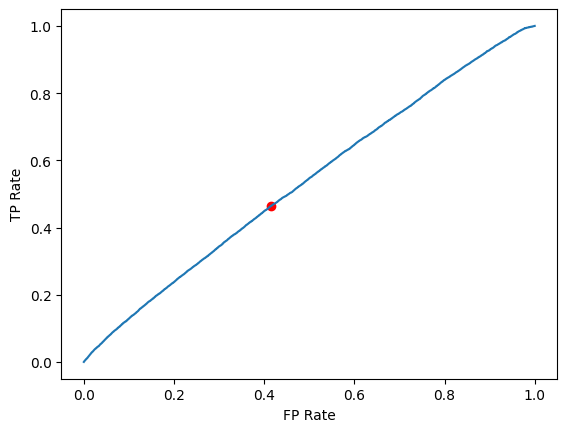

In [72]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_score) #실제 라벨, 예측 라벨

import matplotlib.pyplot as plt

plt.plot(fpr, tpr)

#cut point 위치
fpr_point = 0.41421703640643
tpr_point = 0.46368937185263714
plt.scatter(fpr_point, tpr_point, c='red', marker='o', label=f'Point at ({fpr_point:.2f}, {tpr_point:.2f})')


plt.xlabel('FP Rate')
plt.ylabel('TP Rate')

plt.show()

## AUC Score 구하기

In [74]:
from sklearn.metrics import roc_auc_score

print(roc_auc_score(y_test, y_score))

0.5368827950440419


## CUT POINT 구하기

In [85]:
import numpy as np
#cut point : 민감도 tpr과 특이도 fpr 합이 제일 큰 지점
np.argmax(tpr - fpr)
#그래프에서 표현할 지점
print(fpr[np.argmax(tpr - fpr)], tpr[np.argmax(tpr - fpr)])
#이 때의 threshold 값
print(thresholds[np.argmax(tpr-fpr)] )

0.41421703640643 0.46368937185263714
-0.58844084


In [86]:
#확률값
print(tf.sigmoid(thresholds[np.argmax(tpr - fpr)]))


tf.Tensor(0.35699266, shape=(), dtype=float32)
